# One-Class SVM – Anomaly Detection

This notebook applies a One-Class Support Vector Machine (OC-SVM) for fraud detection.

Objectives:
- Train the model using only normal (non-fraud) transactions
- Evaluate performance on a mixed validation set
- Compare results with Isolation Forest
- Do NOT persist the model unless selected as the final deployment model


In [1]:
# -----------------------------
# Imports & Load Preprocessing Artifacts
# -----------------------------
import sys
import os

# Add project root to Python path
sys.path.append(os.path.abspath(".."))

import numpy as np
import joblib

from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

from src.config import RANDOM_STATE

# Load preprocessing artifacts
ARTIFACT_DIR = "../models"

X_train_scaled = np.load(f"{ARTIFACT_DIR}/X_train_scaled.npy")
X_val_scaled = np.load(f"{ARTIFACT_DIR}/X_val_scaled.npy")
y_val = np.load(f"{ARTIFACT_DIR}/y_val.npy")

print("Artifacts loaded successfully")
print("Train shape:", X_train_scaled.shape)
print("Validation shape:", X_val_scaled.shape)
print("Validation labels shape:", y_val.shape)


Artifacts loaded successfully
Train shape: (227452, 38)
Validation shape: (57355, 38)
Validation labels shape: (57355,)


In [2]:
# -----------------------------
# Train One-Class SVM
# -----------------------------
# One-Class SVM learns the boundary of normal data.
# nu ≈ upper bound on fraction of anomalies
# gamma controls decision boundary complexity

ocsvm = OneClassSVM(
    kernel="rbf",
    nu=0.01,        # slightly higher than true fraud rate
    gamma="scale"
)

# Train ONLY on normal transactions
ocsvm.fit(X_train_scaled)

print("One-Class SVM training completed.")


One-Class SVM training completed.


In [3]:
# -----------------------------
# Anomaly Scoring
# -----------------------------
# One-Class SVM outputs:
#  -1 → anomaly
#   1 → normal
# We convert this into:
#   1 → fraud
#   0 → normal

# Predict on validation set
y_pred_ocsvm = ocsvm.predict(X_val_scaled)

# Convert predictions to fraud labels
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)

# Use decision function scores for ROC-AUC
# Lower scores indicate higher anomaly likelihood
ocsvm_scores = -ocsvm.decision_function(X_val_scaled)

print("Predictions generated.")
print("Predicted fraud count:", y_pred_ocsvm.sum())


Predictions generated.
Predicted fraud count: 1111


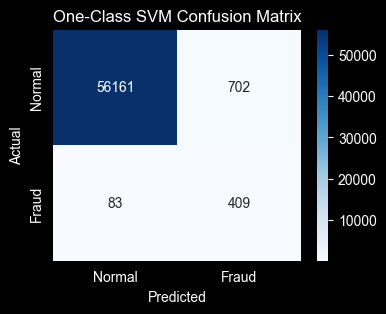

In [5]:
# -----------------------------
# Confusion Metrics
# -----------------------------
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_ocsvm)

# Plot
plt.figure(figsize=(4, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Fraud"],
    yticklabels=["Normal", "Fraud"]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("One-Class SVM Confusion Matrix")
plt.show()


## Confusion Matrix Interpretation

The confusion matrix highlights the detection behavior of the One-Class SVM model:

- **True Positives (409)**: Fraudulent transactions correctly identified, demonstrating strong fraud coverage.
- **False Negatives (83)**: A small number of fraud cases missed, indicating high recall and low financial risk.
- **False Positives (702)**: Legitimate transactions incorrectly flagged as fraud, reflecting increased customer friction.
- **True Negatives (56,161)**: The majority of legitimate transactions are correctly classified.

Overall, the One-Class SVM strongly prioritizes **recall over precision**, successfully detecting most fraudulent transactions at the cost of additional false alerts. This trade-off is suitable for scenarios where minimizing missed fraud is more critical than reducing investigation volume.


In [4]:
# -----------------------------
# Evaluation Metrics
# -----------------------------
# Evaluate One-Class SVM predictions against true labels

precision = precision_score(y_val, y_pred_ocsvm)
recall = recall_score(y_val, y_pred_ocsvm)
f1 = f1_score(y_val, y_pred_ocsvm)
roc_auc = roc_auc_score(y_val, ocsvm_scores)

print("One-Class SVM Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_ocsvm))


One-Class SVM Performance:
Precision: 0.3681
Recall:    0.8313
F1-score:  0.5103
ROC-AUC:   0.9483

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.37      0.83      0.51       492

    accuracy                           0.99     57355
   macro avg       0.68      0.91      0.75     57355
weighted avg       0.99      0.99      0.99     57355



## One-Class SVM Summary

The One-Class SVM model demonstrates strong anomaly detection capability, achieving a high recall of **0.83**, which indicates that the majority of fraudulent transactions are successfully identified. Precision remains moderate at **0.37**, reflecting an increased number of false positives, a common trade-off in fraud detection systems.

The model achieves a **ROC-AUC of 0.95**, comparable to Isolation Forest, confirming its strong ability to rank fraudulent transactions higher than normal ones. However, One-Class SVM is computationally expensive to train and does not scale efficiently to very large datasets, which limits its practicality for real-time, large-scale deployment.

Overall, One-Class SVM is well-suited for scenarios where **maximizing fraud detection (recall)** is critical, but its higher training cost and scalability constraints must be considered when selecting a production model.
